# Introduction

***Warning:*** This is the second notebook of this project. in the first one ("eda_and_feature_engineering"), we define the problem, explored the data, we did an initial treatment and created some features. I strongly recommend that you visit the first script before exploring this one, they are two parts of the same project, and were split just to avoid an extremely large script, improving the organization.

**Method:**

As mentioned, we have already pre-treated our data. However, the EDA revealed that we have ***unbalanced data***, we need to understand witch technique should be used to train our model. In order to build the best possible model, we also need to perform feature selection. 

All considered, we decided to opt for an iterative methodology, as described below:

+ Define and prepare metrics to be easily applicable 
+ Develop a pipeline to build a model and create a baseline with the raw DataFrame
+ Treat the imbalance data problem and choose the best technique
+ Feature selection and engineering
+ Model selection and hyperparameter tuning


# Libs

In [1]:
import pandas as pd 
import numpy as np
import math as mt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Metrics

**Defining metrics**

Evaluating a classification model may not be the easiest task. In order to obtain a consistent result it will be necessary to use a set of metrics, we will adopt:

+ recall -- Indicates the occurrence of false negative, e.g, predict indicated that default would NOT occur, but it did
+ precision -- Indicates rate at which positive predictions are correct, e.g, predict indicated that default would occur, and it did
    + Please note: in our case, **recall will have greater relevance**, because predicting a false negative will result in greater losses for the business than predicting a false positive
+ F1 -- A function of Precision and Recall. Even though Recall is more important, precision is also relevant, because wrongly predicting that a default will happen, also results in business loses. So it is good to have a metric that represents a balance between Precision and Recall. 
+ ROC Curve -- Until now, our metrics are considering 3 of 4 values of the confusion matrix, we are not looking at true negatives! We could use Accuracy or Specificity to include true negative in our analyses, but we expected that the majority of data will be true negative, so those metrics may be misleading. Instead, we will use the ROC curve, that shows the relation between  True Positive Rate and True Negative Rate. 
+ AUC -- Its the area under the ROC curve, it is a simple way to measure the ROC Curve.


***To make our life easier, we will define a class that calculates and displays all the desired metrics***

**Important:**

To make our notebook easier to read and our work more scalable, we separate our class and functions that calculates metrics and show relevant charts in a .py file, and here, we will just import it. ***Please, check the file classification.py found in this same repository for better understanding***

Inside classification.py we have:
+ Definition of Metrics class that receive two lists (list of predict default and list of actual default) Ex: ***my_metrics = classification.Metrics(y_true,y_pred)***
    + Define the desired metrics as attributes and print it. Ex: ***my_metrics.show_metrics()***
    + Plot metrics chart (may be: Confusion Matrix, ROC Curve or both) and display then. Ex: ***my_metrics.show_charts()***
    + print metrics and display all charts. Ex: ***my_metrics.show_all()***
    
We also have a function to calculate mean metrics, generate overlapped charts, and other useful infos for multiple Metrics objects. Please note that To prevent overfitting, we will use Stratified K-Folds cross-validator to evaluate our models. Therefore, it will be interesting to have a function that can receive multiple metrics objects (one for each fold). 
+ Ex of function usage: ***classification.show_mean_metrics([my_metrics,my_metrics2,my_metrics3])***


In [2]:
# Importing classification.py

import classification

# Building the model and Treating Imbalance

## Building pipeline functions and a Baseline 

Now that we we define and prepare our metrics, its time to develop the model! Following the logic defined in our method, we are going to create some functions to facilitate the definition of differents pipelines.

***The pipeline will:***
+ Receive the features as keywords (X,y)
+ Use StratifiedKFold cross validation technique to divide the data in 10 (or n) folds
    + We will use StratifiedKFold instead of normal K-fold  to preserve the percentage of samples for the target category in each fold.
+ Pre processing the training data ***(isolating test data to avoid overfitting)***. ps: Step not included in in the definition of baseline 
+ Build a Classifier model for each fold and make predictions with the validation data. 
    + We will start using a Random Forest model, which usually performs well in this type of problem. At the end of the work, we will evaluate other models
+ Calculate metrics for each fold using our pre defined Metrics class, and display a summary of the results.

***This way, we can obtain a baseline with the original data, without any type of treatment, and as we process the data (treating imbalance and doing feature engineering) it will be easier to test our hypotheses and evaluate our improvement!***

In [3]:
def divide_kfolds(X,y,n = 10):
    
    """Return 4 lists containing training and validation data, divided in n Stratified KFolds

    Keyword arguments:
    X -- Independent features - excluding target variable 
    y -- Dependent variable - target
    n -- Number of folds (default = 10)
    """

    # Create the StratifiedKFold object
    skf = StratifiedKFold(n_splits=n, shuffle=True)

    X_train_list,X_test_list,y_train_list,y_test_list = [[] for i in range(4)]
    # Split features in folds
    for train_index, test_index in skf.split(X,y):

        X_train_list.append(X.loc[train_index])
        X_test_list.append(X.loc[test_index])
        y_train_list.append(y.loc[train_index])
        y_test_list.append( y.loc[test_index])

    return X_train_list, X_test_list, y_train_list,y_test_list
    

In [4]:
def evaluate_randon_forest(X_train_list, X_test_list, y_train_list,y_test_list):
    
    """Show all pre-defined metrics for a Random Forest model, trained and tested with n-folds defined in args 
    * Train a Random Forest Classifier model for each fold 
    * For each model, predict y with test data 
    * For each model, create a metrics object with actual and predicted y, and use it to print "mean metrics"

    Keyword arguments:
    x_train_list -- list with n folds for training the model 
    x_test_list -- list with n folds for testing the model 
    y_train_list -- list with n folds containing training dependent variable (target)
    y_test_list -- list with n folds containing test dependent variable (target)
    """

    metrics_list =[]
    # Split features in folds
    for X_train, X_test, y_train,y_test in zip(X_train_list, X_test_list, y_train_list,y_test_list):

        # Creating a Random Forest Classifier with standard hyperparameters. 
        # We will do hyperparameter tuning in the appropriate time
        rfc = RandomForestClassifier(random_state=42)
        rfc.fit(X_train, y_train)
        
        rfc_predict = rfc.predict(X_test)
        
        prov_metrics = classification.Metrics(y_test,rfc_predict)
        metrics_list.append(prov_metrics)
        
    # Show metrics
    classification.show_mean_metrics(metrics_list)
    

***First of all, lets load our pre-treated DataFrame and establish a baseline!***

In [5]:
# Loading df
default_credit_card = pd.read_csv(r'data\default_of_credit_card_clients_treated.csv')
default_credit_card.head(3)

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month,age_range,age_range_int,sum_pay,mean_bill,mean_pay_amt
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,1,23-25,19,-2,7704.0,689.0
1,120000,2,2,2,26,-1,2,0,0,0,...,1000,1000,0,2000,1,25-26,6,3,17077.0,5000.0
2,90000,2,2,2,34,0,0,0,0,0,...,1000,1000,1000,5000,0,33-34,5,0,101653.0,11018.0


For the Baseline, we will ***keep only continuous and originals features*** (before feature engineering)

***Evaluation Pipeline (Baseline):***

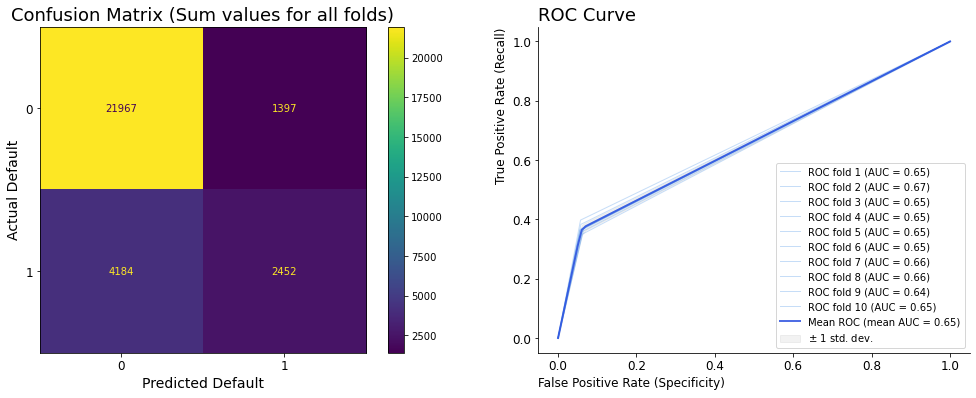

Métrics:

Mean Recall = 0.369 | Recall Std = 0.01
Mean Precision = 0.637 | Precision Std = 0.02
Mean F1 = 0.468 | F1 Std = 0.01
Mean AUC = 0.655 | AUC Std = 0.01


In [6]:
# Removing categorical features and target 
X  = default_credit_card.loc[:,['limit_bal'] + default_credit_card.columns[5:23].tolist()]
# Geting target
y = default_credit_card.default_payment_next_month

# Spliting data into training and validation k-folds and appending folds to lists
X_train_list, X_test_list, y_train_list, y_test_list = divide_kfolds(X, y)

#Evaluating Baseline with raw data (Randon Forest classifier)
evaluate_randon_forest(X_train_list, X_test_list, y_train_list,y_test_list)

***As expected, we had really bad results!*** After all, we simply created a model with the raw data, without any treatment. 

let's start dealing with the imbalance data problem and see how much we can improve the results


## Treating Imbalance

To combat imbalanced we will try four different techniques:

+ Under-sampling (resampling data)
+ Over-sampling (resampling data)
+ SMOTE (Generate Synthetic Samples)
+ SMOTE + Under-Sampling

### Under-Sampling

Under-sampling consists in deleting data from the majority class until we have balanced data, i.e, an equal number of examples for each class.

A potential problem with this technique is that if the imbalance is severe, a lot of data will be deleted, which can make the differences between classes more difficult to learn.

To implement this technique we will use ***RandomUnderSampler***.  From [documentation](https://imbalanced-learn.org/stable/under_sampling.html) we found the definition: "RandomUnderSampler is a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes"

let's develop a function to apply Under-sampling in n k-folds, so we can include this processing in our model pipeline, ***applying only in training data***.

In [7]:
def undersampling_kfolds(X_train_list,y_train_list):
    
    """return n training data folds with Under-sampling technique applied
    * It is very important to apply this processing only in the training that
    * this way, our validation data will remain faithful to a real production situation,avoiding overfitting

    Keyword arguments:
    X_train_list -- list with n folds for training the model 
    y_train_list -- list with n folds containing training dependent variable (target)
    """
    
    # Define undersample strategy
    # “majority” will undersample the majority class determined by the class with the largest number of examples.  
    undersample = RandomUnderSampler(sampling_strategy='majority',random_state = 42)

    # Process training data and append resampled folds to lists
    X_under_resampled_list, y_under_resampled_list = [[] for i in range(2)] 
    for X_train, y_train in zip(X_train_list,y_train_list):
        X_under_resampled, y_under_resampled = undersample.fit_resample(X_train, y_train)
        X_under_resampled_list.append(X_under_resampled)
        y_under_resampled_list.append(y_under_resampled)
        
    return X_under_resampled_list,y_under_resampled_list
                                              

***Evaluation Pipeline:***

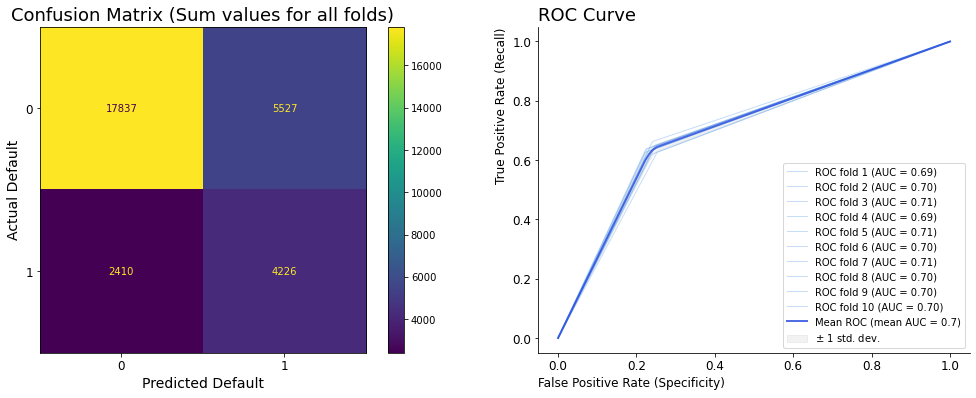

Métrics:

Mean Recall = 0.637 | Recall Std = 0.01
Mean Precision = 0.434 | Precision Std = 0.01
Mean F1 = 0.516 | F1 Std = 0.01
Mean AUC = 0.7 | AUC Std = 0.01


In [8]:
# Spliting data into training and validation k-folds and appending folds to lists
X_train_list, X_test_list, y_train_list, y_test_list = divide_kfolds(X, y)

# Appling Undersampling ONLY IN TRAING DATA
X_under_resampled_train_list,y_under_resampled_train_list = undersampling_kfolds(X_train_list,y_train_list)

#Evaluating Model with Undersampling treatment (Randon Forest classifier)
evaluate_randon_forest(X_under_resampled_train_list, X_test_list, y_under_resampled_train_list,y_test_list)

***For sure we lost a good amount of data, but now we have balanced data. Because of that, we achieved a great improvement over our baseline!***

Although we noticed a small improvement in the ROC Curve (mean AUC went from 0.65 to 0.7) ***the biggest improvement can be seen in the Recall, which went from 0.37 to 0.64!*** This means that we are having a lot less false negative. 

However, the loss of data seems to have had a negative impact on the model, as the improvement in other metrics was very subtle. Let's try other techniques that can alleviate this problem. 

### Over-Sampling

Over-sampling has a similar principle to under-sampling, but instead of deleting data, we will duplicate examples from the minority class. 

A potential problem with this technique is that it may increase the likelihood of occurring overfitting, since it makes exact copies of the minority class examples.
  
To implement this technique we will use RandomOverSampler class, to randomly duplicate samples of minority class

let's develop a function to apply Over-sampling in n k-folds, so we can include this processing in our model pipeline, ***applying only in training data***.

In [9]:
def oversampling_kfolds(X_train_list,y_train_list):
    
    """return n training data folds with over-sampling technique applied
    * It is very important to apply this processing only in the training that
    * this way, our validation data will not be contaminated,avoiding overfitting

    Keyword arguments:
    X_train_list -- list with n folds for training the model 
    y_train_list -- list with n folds containing training dependent variable (target)
    """
    
    # Define oversampling strategy
    # “minority” will automatically balance the minority class with majority class
    oversample = RandomOverSampler(sampling_strategy='minority',random_state = 42)

    # Process training data and append resampled folds to lists
    X_over_resampled_list, y_over_resampled_list = [[] for i in range(2)] 
    for X_train, y_train in zip(X_train_list,y_train_list):
        X_over_resampled, y_over_resampled = oversample.fit_resample(X_train, y_train)
        X_over_resampled_list.append(X_over_resampled)
        y_over_resampled_list.append(y_over_resampled)
        
    return X_over_resampled_list,y_over_resampled_list
                                              

***Evaluation Pipeline:***

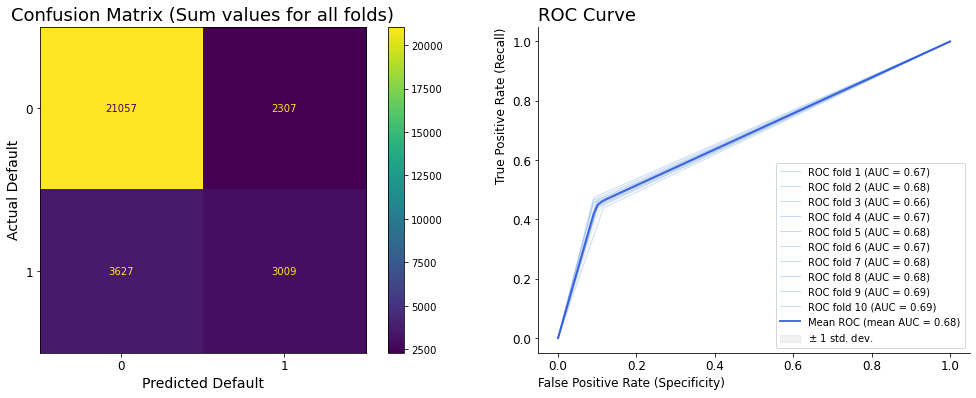

Métrics:

Mean Recall = 0.453 | Recall Std = 0.01
Mean Precision = 0.566 | Precision Std = 0.02
Mean F1 = 0.504 | F1 Std = 0.01
Mean AUC = 0.677 | AUC Std = 0.01


In [10]:
# Spliting data into training and validation k-folds and appending folds to lists
X_train_list, X_test_list, y_train_list, y_test_list = divide_kfolds(X, y)

# Appling Oversampling ONLY IN TRAING DATA
X_over_resampled_train_list,y_over_resampled_train_list = oversampling_kfolds(X_train_list,y_train_list)

#Evaluating Model with Oversampling treatment (Randon Forest classifier)
evaluate_randon_forest(X_over_resampled_train_list, X_test_list, y_over_resampled_train_list,y_test_list)

***We solved the imbalance problem, but we have a lot of repeated data***

We were still able to improve our baseline, but comparing with under-sampling, we have a significant ***worsening in the Recall, going from 0.64 to 0.45.***

On the other hand, we have an ***improvement in Precision, going from 0.43 to 0.57***

This show that using oversampling or under-sampling represents a ***trade off between Recall and Precision***, i.e, using under-sampling we choose to prioritize the reduction of false negative rate, and using oversampling we choose to prioritize correct positive predictions.


In the metrics section, we have already established that speaking about credit card default, predicting a false negative can have serious consequences for the business, that is, in our case, recall is more important than precision, and therefore the ***under-sampling technique is more appropriate then oversampling.***

Lets try the SMOTE resampling technique to see if we can find a result that matches a good Recall and a good precision.

### SMOTE

Just like the oversampling technique, SMOTE (Synthetic Minority Oversampling Technique) intends to oversample the minority class. But instead of duplicating data, SMOTE creates new data from the existing examples. 

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

let's try it out!

In [11]:
def smote_kfolds(X_train_list,y_train_list):
    
    """return n training data folds with smotesampling technique applied
    * It is very important to apply this processing only in the training that
    * this way, our validation data will not be contaminated,avoiding smotefitting

    Keyword arguments:
    X_train_list -- list with n folds for training the model 
    y_train_list -- list with n folds containing training dependent variable (target)
    """
    
    # Define SMOTE
    smote_oversample = SMOTE(random_state = 42)

    # Process training data and append resampled folds to lists
    X_smote_resampled_list, y_smote_resampled_list = [[] for i in range(2)] 
    for X_train, y_train in zip(X_train_list,y_train_list):
        X_smote_resampled, y_smote_resampled = smote_oversample.fit_resample(X_train, y_train)
        X_smote_resampled_list.append(X_smote_resampled)
        y_smote_resampled_list.append(y_smote_resampled)
        
    return X_smote_resampled_list,y_smote_resampled_list
                                              

***Evaluation Pipeline:***

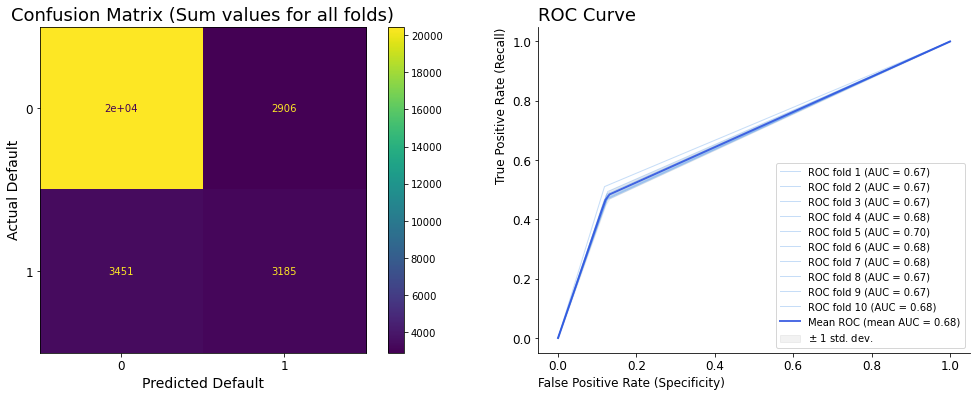

Métrics:

Mean Recall = 0.48 | Recall Std = 0.01
Mean Precision = 0.523 | Precision Std = 0.01
Mean F1 = 0.5 | F1 Std = 0.01
Mean AUC = 0.678 | AUC Std = 0.01


In [12]:
# Spliting data into training and validation k-folds and appending folds to lists
X_train_list, X_test_list, y_train_list, y_test_list = divide_kfolds(X, y)

# Appling SMOTE Oversampling ONLY IN TRAING DATA
X_smote_resampled_train_list,y_smote_resampled_train_list = smote_kfolds(X_train_list,y_train_list)

#Evaluating Model with SMOTE treatment (Randon Forest classifier)
evaluate_randon_forest(X_smote_resampled_train_list, X_test_list, y_smote_resampled_train_list,y_test_list)

in general, we observed a small worsening in the results

Comparing to oversampling, there is a tread off between Recall (small improvment) and precision (small worsening). 

Considering that mean AUC and mean F1 are worse or equal to both, oversampling and undersampling, this small tread off is not paying off. 

***The best technique for our case still is undersampling***

### SMOTE + Under-Sampling

In [the original SMOTE paper](https://arxiv.org/pdf/1106.1813.pdf), the best results were obtained by using a  Under-sampling and SMOTE Combination. 

This is because applying SMOTE to achieve an equal balance with the majority class is not necessarily the best case for the classifier. Thus, we can under-sample the majority to different percentages of the original majority class (say 25%, 50%, 75%) , and then, apply SMOTE to minority samples.

let's try it out!

In [13]:
def smote_undersampling_kfolds(X_train_list,y_train_list,under_rate):
    
    """return n training data folds with a combination of SMOTE and Under-Sampling technique applied
    * It is very important to apply this processing only in the training that
    * this way, our validation data will not be contaminated,avoiding smotefitting

    Keyword arguments:
    X_train_list -- list with n folds for training the model 
    y_train_list -- list with n folds containing training dependent variable (target)
    under_rate -- The rate of Under-Sampling strategy
    """
 
    undersample = RandomUnderSampler(sampling_strategy = under_rate,random_state = 42)
    smote_oversample = SMOTE(random_state = 42)

    # Process training data and append resampled folds to lists
    X_smote_resampled_list, y_smote_resampled_list = [[] for i in range(2)] 
    for X_train, y_train in zip(X_train_list,y_train_list):
        X_under_resampled, y_under_resampled = undersample.fit_resample(X_train, y_train)
        X_smote_under_resampled, y_smote_under_resampled = smote_oversample.fit_resample(X_under_resampled, y_under_resampled)
        
        
        X_smote_resampled_list.append(X_smote_under_resampled)
        y_smote_resampled_list.append(y_smote_under_resampled)
        
    return X_smote_resampled_list,y_smote_resampled_list
                                              

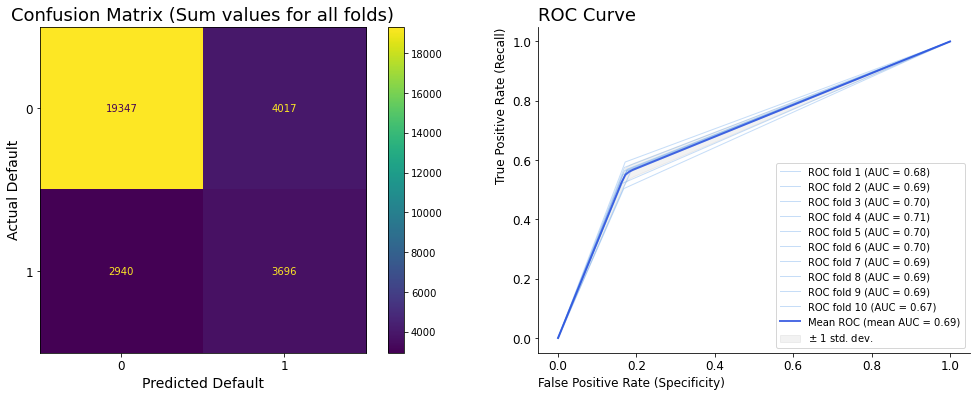

Métrics:

Mean Recall = 0.557 | Recall Std = 0.02
Mean Precision = 0.479 | Precision Std = 0.01
Mean F1 = 0.515 | F1 Std = 0.02
Mean AUC = 0.693 | AUC Std = 0.01


In [26]:
# Spliting data into training and validation k-folds and appending folds to lists
X_train_list, X_test_list, y_train_list, y_test_list = divide_kfolds(X, y)

# Appling SMOTE Oversampling ONLY IN TRAING DATA
X_smote_under_train_list,y_smote_under_train_list = smote_undersampling_kfolds(X_train_list,y_train_list,under_rate = 0.5)

#Evaluating Model with SMOTE treatment (Randon Forest classifier)
evaluate_randon_forest(X_smote_under_train_list, X_test_list, y_smote_under_train_list,y_test_list)

although we tried a number of different values for sampling_strategy, ***we were unable to obtain a significant overall improvement (AUC and F1).***

However, ***we were able to achieve a great balance between Precision and Recall***, witch can be very usefull in some projects.

Unfortunately, this is not our case. We know that Recall is the metric that will have the biggest impact on the business, and should be prioritized. 

So in our case, ***Under-Sampling is the best choice between all tested technique!***

# Feature selection and engineering